<div style='background-image: url("https://www.geophysik.uni-muenchen.de/ROMY/theme/images/ringlaser_wideformat.jpg") ; padding: 0px ; background-size: cover ; border-radius: 15px ; height: 250px; background-position: 0% 80%'>
    <div style="float: left ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 35% ; height: 150px">
        <div style="position: relative ; top: 50%;  transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.9) ; line-height: 100%"> <br>ROMY - <br><br>  Synthetic Sagnac Processing </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.7)"></div>
        </div>
    </div>

## Import 

### Official Libraries

In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
import time 

from scipy.signal import resample, hilbert, correlate
from tqdm import tqdm
from obspy import UTCDateTime



### Own Processing Methods

In [5]:
import sys
sys.path.insert(0, 'submodules')

In [6]:
from EchoPerformance import __echo_performance
from CreateSyntheticEventV2 import __create_synthetic_event_v2
from MakeplotDemodulationQuality import __makeplot_demodulation_quality
from MinimizeResidual import __minimize_residual
from CreateLinearChirp import __create_linear_chirp
from Tapering import __tapering
from InstaFreqHilbert import __insta_freq_hilbert
from Normalize import __normalize
from WriteToMseed import __write_to_mseed
from LoadMseed import __load_mseed
from Modulation import __modulation
from QuerrySeismoData import __querry_seismo_data


In [7]:
def third_order_derive(x, pos="MIDDLE"):

    coeff = np.zeros((5,5))
    norm = np.array([0,0])
    sum = 0.

    norm[0] = 12.;
    norm[1] = 84.;

    coeff[0][0] = -125.;
    coeff[0][1] =  136.;
    coeff[0][2] =   48.;
    coeff[0][3] =  -88.;
    coeff[0][4] =   29.;
    coeff[1][0] =  -38.;
    coeff[1][1] =   -2.;
    coeff[1][2] =   24.;
    coeff[1][3] =   26.;
    coeff[1][4] =  -10.;
    coeff[2][0] =    1.;
    coeff[2][1] =   -8.;
    coeff[2][2] =    0.;
    coeff[2][3] =    8.;
    coeff[2][4] =   -1.;
    coeff[3][0] =   10.;
    coeff[3][1] =  -26.;
    coeff[3][2] =  -24.;
    coeff[3][3] =    2.;
    coeff[3][4] =   38.;
    coeff[4][0] =  -29.;
    coeff[4][1] =   88.;
    coeff[4][2] =  -48.;
    coeff[4][3] = -136.;
    coeff[4][4] =  125.;

    for i in range(0, 5):
        sum += coeff[pos][i]*x[i];
    
    if pos == 'MIDDLE':
        sum /= norm[0];
    
    else:
        sum /= norm[1];


    return sum

(0.0, 10.0)

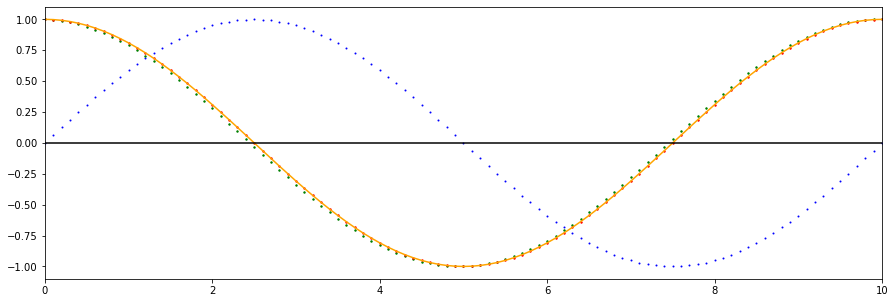

In [8]:
import numpy as np 

dt = 0.1
f = 0.1
t = np.arange(0, 100, dt)
y = np.sin(2*np.pi* f * t)
y2 = np.cos(2*np.pi* f * t)

# dy1 = third_order_derive(y)
dy2 = np.diff(y, n=1)/(2*np.pi*f)/dt
# dy3 = np.diff(y, n=2)/dt/dt
dy3 = np.gradient(y, edge_order=1)/(2*np.pi*f)/dt

plt.figure(figsize=(15,5))

plt.scatter(t,y,s=1, color='blue')
plt.plot(t, y2, color='orange')

plt.scatter(t[:-1], dy2, s=2, color="green")
plt.scatter(t, dy3, s=2, color="red")


plt.axhline(0, color='k')
plt.xlim(0,10)

### Own Plotting Methods

In [9]:
from MakeplotTraceAndSpectrum import __makeplot_trace_and_spectrum
from MakeplotTraceAndPSD import __makeplot_trace_and_psd
from MakeplotModulatedSignal import __makeplot_modulated_signal

## Configurations

In [10]:

oversampling = 1

T = 1600

sps = 5000

sgnc = 550

f_lower, f_upper = 0.001, 0.05

# modulation_index = 1.0

# frequency_deviation = 0.5
# modulation_index = frequency_deviation/f_upper

modulation_scheme = 3


taper_type = "window"
taper_percent = 0.2


syn_signal = 'synthetic_trace'  ## 'chirp' or 'synthetic_trace' or 'real_trace'



## Get Synthetic Signal

#### Random Trace Signal or Chirp

In [141]:
sps = sps * oversampling

In [142]:
if syn_signal == 'synthetic_trace':

    ##_______________________________________________________________
    ## call synthetic event generator (version2)

    ## load trace or create and write one if not yet existing

    iname=f"data/SYN_T{int(T)}_fs{int(sps)}_f{f_lower}-{f_upper}.mseed"

    modeltrace, time_modeltrace = __load_mseed(iname, T, sps, f_lower, f_upper)

#     modeltrace = __tapering(modeltrace, taper_type, taper_percent)

     ## normalize trace to avoid issues with demodulation
    modeltrace = __normalize(modeltrace)

## ______________________________________________
elif syn_signal == 'chirp':
    ##_______________________________________________________________
    ## make chirp signal
    
    modeltrace, time_modeltrace = __create_linear_chirp(T, 
                                                        sps, 
                                                        f_lower, 
                                                        f_upper,
                                                       )

## ______________________________________________
elif syn_signal == 'real_trace':
    
    ## set starttime and endtime
    tbeg = UTCDateTime(2020, 10, 30, 12, 0)
    tend = tbeg + T
    
    ## get stream data
    RLAS, RLAS_inv = __querry_seismo_data("BW.RLAS..HJZ", 
                                          tbeg, 
                                          tend, 
                                          restitute=True,
                                          )
    
    RLAS[0].resample(sampling_rate=sps)
    
    RLAS[0].filter('bandpass', freqmin=f_lower, freqmax=f_upper, corners=4, zerophase=True)
    
    time_modeltrace = np.arange(0, T+1/sps, 1/sps)
    modeltrace = RLAS[0].data[0:time_modeltrace.size]
    
    modeltrace = __normalize(modeltrace)
    
## ______________________________________________*
else:
    print("Wrong choise!")
    

stored synthetic event to: data/SYN_T1600_fs5000_f0.001-0.05.mseed


Apply taper to avoid edge effects (not really necessary)


In [143]:
modeltrace = __tapering(modeltrace, taper_type='window', percent=0.2)

Display the synthetic signal trace, which is modulated onto the carrier.

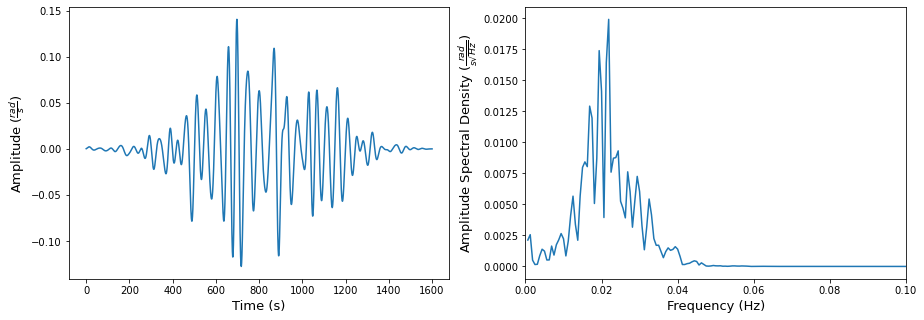

In [144]:
__makeplot_trace_and_spectrum(modeltrace, time_modeltrace, fmax=2*f_upper);

Possibility to write modeltrace and time axis to a stream as .mseed to load it in an other script. Load a trace enhances comparability since it is not randomly gereated each time.

In [145]:
# oname = f'data/syn_T{int(T)}_fs{int(sps)}_f{f_lower}-{f_upper}.mseed'

# __write_to_mseed(modeltrace, time_modeltrace, oname, sps)

# Modulation

In [146]:
# timeline, synthetic_signal = __modulation(modeltrace, time_modeltrace, T, sps, mod_index=modulation_index)


synthetic_signal, timeline = __modulation(modeltrace,
                                          time_modeltrace, 
                                          sgnc, 
                                          T, 
                                          sps, 
                                          modulation_index, 
                                          modulation_scheme,
                                         )



Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 3.36 sec


### Taper

In [147]:
# synthetic_signal = __tapering(synthetic_signal, taper_type='window', percent=0.2)

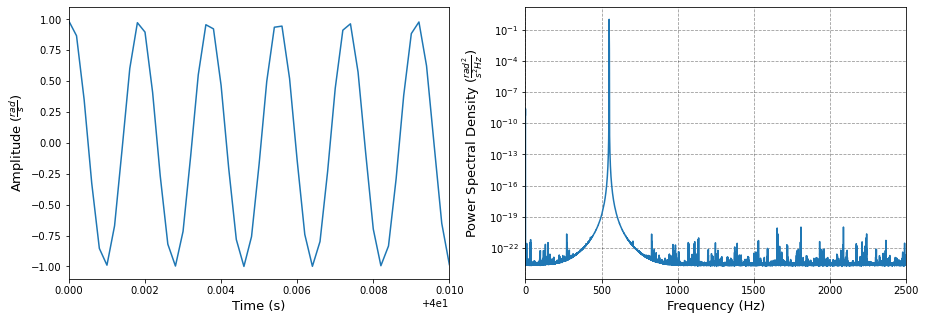

In [148]:
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps, t1=40, t2=40.01);

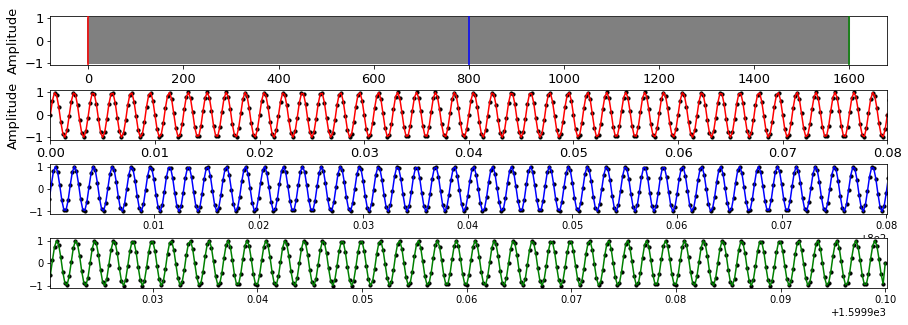

In [149]:
__makeplot_modulated_signal(synthetic_signal,timeline);

### Downsample

The modulation has been performed with an oversampling factor to avoid erros. Now the result is resampled mimicing the real sampling of the analog signal.

In [150]:
# sps /= oversampling


# real_time = np.arange(0,T+1/sps,1/sps)

# tmp1 = np.interp(real_time, time_modeltrace, modeltrace)
# tmp2 = np.interp(real_time, modeltrace, time_modeltrace)
# tmp3 = np.interp(real_time, timeline, synthetic_signal)

# timeline = real_time

# modeltrace = tmp1
# time_modeltrace = tmp2
# synthetic_signal = tmp3

In [151]:
modeltrace = modeltrace[::oversampling]
time_modeltrace = time_modeltrace[::oversampling]

synthetic_signal = synthetic_signal[::oversampling]
timeline = timeline[::oversampling]

sps = 1/(timeline[1]-timeline[0])

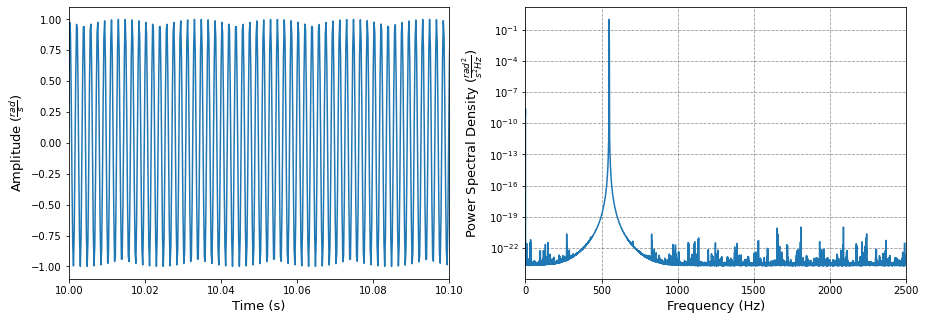

In [152]:
__makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps, t1=10, t2=10.1);

# Demodulation

In order to evaluate the demodulated signal it is compared to the kown synthetic signalthe. For this, the median is substracted and 1% of the edges are cut off. Then both, the orignal and the retrieved signal are normalized and a cross-correlation calculated.

In [153]:

# time_demod_signal, demod_signal = __insta_freq_hilbert(synthetic_signal, timeline, sps, sgnc)


1 nan removed !


In [156]:

def __hibert_filter(sig_in, time_in, fs):
    
    '''
    estimating the instantaneous frequency by using the formula of Jo
    
    sig_in    = input signal
    time_in   = input timeline
    fs        = sampling frequency of digital signal
    '''
    
    ## calulcate hilbert transform
    hil0 = hilbert(sig_in)
    
    ## extract imaginary part of hilbert transform 
    hil = np.imag(hil0)
    
    
    ## calculate derivatives 
    d_hil = np.gradient(hil, edge_order=1)
    d_sig = np.gradient(sig_in, edge_order=1)
    
    delta_f_full = (sig_in * d_hil - d_sig * hil) / (2*np.pi*np.sqrt(sig_in**2 + hil**2))
# #     delta_f_full = (sig_in[1:]*np.diff(hil) - np.diff(sig_in) * hil[1:]) / (2*np.pi*np.sqrt(sig_in[1:]**2 + hil[1:]**2))

    ## extract real part
    delta_f = np.real(delta_f_full)
    
    
    ## instert nan value for time zero (exluded bevause of np.diff() ) 
    sum0, idx = 0, []
    for k, x in enumerate(demod_signal):
        if np.isnan(x):
            sum0 += 1
            idx.append(k)
    print(sum0, " nan found")
    
    for l in idx:
        delta_f[l] = 0

    
    ## _______________________________________________________________________________

#    return time_in[1:], delta_f
    return time_in, delta_f


In [157]:

time_demod_signal, demod_signal = __hibert_filter(synthetic_signal, timeline, sps)


0  nan found


### Remove Offset

In [158]:
print(f"theo. Sagnac Frequencs: {sgnc} Hz")
print(f"Median Demodulated Signal: {np.median(demod_signal)}")

# demod_signal = demod_signal - sgnc
demod_signal = demod_signal - np.median(demod_signal)

theo. Sagnac Frequencs: 550 Hz
Median Demodulated Signal: 0.10144906629890042


### Remove Edges

In [159]:
cutoff = int(0.01*demod_signal.size)

cut1 = np.array([i for i in demod_signal[:cutoff]])
cut2 = np.array([i for i in demod_signal[-cutoff:]])
demod_signal[:cutoff] = 0
demod_signal[-cutoff:] = 0

### Normalize

In [160]:
demod_signal_norm = __normalize(demod_signal)
modeltrace_norm = __normalize(modeltrace)

# demod_signal_norm = __tapering(demod_signal_norm, 'flanks', percent=0.1)

### Cross-Correlation

In [161]:
cross_corr = correlate(demod_signal, modeltrace, mode='same')

cross_corr_lags = np.arange(-cross_corr.size//2+1,cross_corr.size//2+1,1)

### Final Plotting


optimized: original -  1.0 * model + -0.0

0.000518802743586


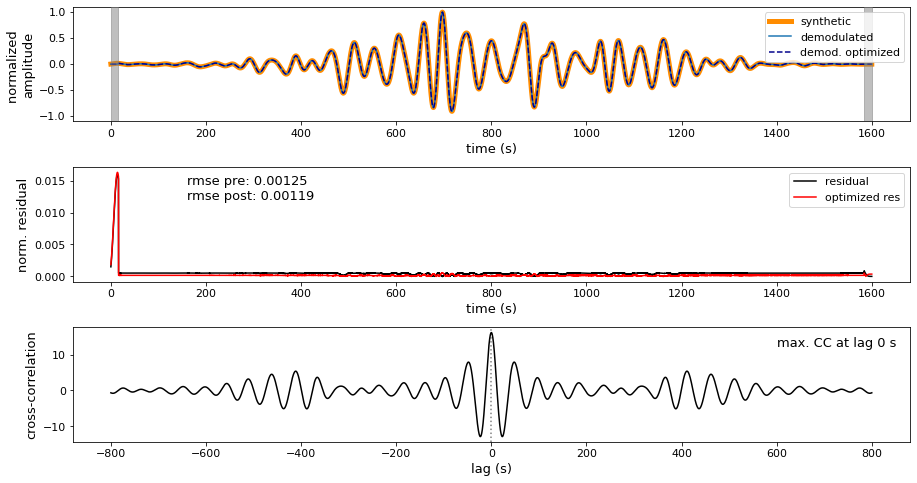

In [162]:

fig = __makeplot_demodulation_quality(timeline, 
                                      modeltrace_norm, 
                                      demod_signal_norm,
                                      cross_corr,
                                      cross_corr_lags,
                                      cut1,
                                      cut2,
                                     );


### Save Plot

In [28]:
pname = f"{syn_signal}_{f_lower}-{f_upper}_T{int(T)}_fs{int(sps)}_mi{modulation_index}_S{int(sgnc)}_case{modulation_scheme}.pdf"

fig.savefig(f"plots/{pname}", dpi=300, format='pdf')

In [29]:

# def __modulation(modeltrace, time_modeltrace, T, sps, mod_index=0.1):

#     timeline = time_modeltrace

#     Npts = int(T*sps)

#     # tt = np.arange(0, T, 1/sps/fraction)
#     tt = time_modeltrace

# #     modulation_index = abs(f_upper-sgnc)/f_upper
# #     print(modulation_index)
    
#     fm = sgnc + mod_index * modeltrace




#     print(' Integrating ... ')
#     t1 = time.time()

#     ifm = np.zeros(Npts+1)
#     summe = 0

#     for i in range(0, Npts+1):
#         summe += fm[i]
#         ifm[i] = 2*np.pi*summe

#     ifm = ifm / sps # to finish integral

#     t2 = time.time()

#     __echo_performance(t1, t2)



#     synthetic_signal = np.sin( 2 * np.pi * ifm )
#     # synthetic_signal = np.cos( 2 * np.pi * ifm )

#     # synthetic_signal = np.cos(2*np.pi * (sgnc + 0.01 * ifm ))

#     # synthetic_signal = 1.0 * np.sin(2*np.pi*sgnc * timeline - 0.001 * np.cos(modeltrace*timeline))

#     return timeline, synthetic_signal
